# Hodgkin-Huxley Neuron Model

## Introduction

The Hodgkin-Huxley (HH) model (1952) is the foundational biophysical model of how action potentials are generated in neurons. Alan Hodgkin and Andrew Huxley developed it based on experiments on the squid giant axon, and it earned them the Nobel Prize in Physiology in 1963.

The model describes the **electrical behavior of the neuron membrane** using a set of coupled ordinary differential equations (ODEs). It treats the membrane as an electrical circuit with:
- A **capacitor** (the lipid bilayer storing charge)
- **Voltage-gated ion channels** for sodium (Na⁺) and potassium (K⁺)
- A **leak channel** representing passive ion flow

Understanding this model is essential for computational neuroscience because:
1. It explains how individual neurons fire action potentials
2. It is the basis for all biophysically realistic neural network models
3. Network-level phenomena like **sharp-wave ripples and oscillations** in the hippocampus emerge from populations of HH-type neurons

---

## The Mathematics

### Membrane Voltage Equation

The core equation describes how membrane voltage $V$ changes over time:

$$C_m \frac{dV}{dt} = I_{ext} - I_{Na} - I_K - I_L$$

Where:
- $C_m$ = membrane capacitance (µF/cm²)
- $I_{ext}$ = external injected current
- $I_{Na}$ = sodium current
- $I_K$ = potassium current  
- $I_L$ = leak current

### Ion Currents

Each current is defined by its conductance and driving force (Ohm's law):

$$I_{Na} = g_{Na} \cdot m^3 h \cdot (V - E_{Na})$$
$$I_K = g_K \cdot n^4 \cdot (V - E_K)$$
$$I_L = g_L \cdot (V - E_L)$$

### Gating Variables

The variables $m$, $h$, and $n$ are **gating variables** (values between 0 and 1) that represent the probability of ion channel subunits being in the open state:
- $m$ = Na⁺ activation gate (opens fast with depolarization)
- $h$ = Na⁺ inactivation gate (closes after depolarization — causes refractory period)
- $n$ = K⁺ activation gate (opens slower, repolarizes membrane)

Each obeys a first-order ODE:

$$\frac{dx}{dt} = \alpha_x(V)(1-x) - \beta_x(V) \cdot x$$

where $\alpha_x$ and $\beta_x$ are empirically derived voltage-dependent rate functions.


## 1. Setup and Parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# ─── Membrane parameters ───────────────────────────────────────────────────────
Cm   = 1.0    # Membrane capacitance (µF/cm²)

# ─── Maximum conductances (mS/cm²) ────────────────────────────────────────────
gNa  = 120.0  # Sodium
gK   = 36.0   # Potassium
gL   = 0.3    # Leak

# ─── Reversal potentials (mV) ─────────────────────────────────────────────────
ENa  = 50.0   # Sodium reversal potential
EK   = -77.0  # Potassium reversal potential
EL   = -54.4  # Leak reversal potential

print("Parameters loaded.")
print(f"  Sodium:    gNa={gNa} mS/cm², ENa={ENa} mV")
print(f"  Potassium: gK={gK}  mS/cm², EK={EK}  mV")
print(f"  Leak:      gL={gL}  mS/cm², EL={EL} mV")

Parameters loaded.
  Sodium:    gNa=120.0 mS/cm², ENa=50.0 mV
  Potassium: gK=36.0  mS/cm², EK=-77.0  mV
  Leak:      gL=0.3  mS/cm², EL=-54.4 mV


## 2. Voltage-Dependent Rate Functions

These $\alpha$ and $\beta$ functions were fit empirically by Hodgkin & Huxley to their experimental data. They determine how fast the gates open and close at each voltage.

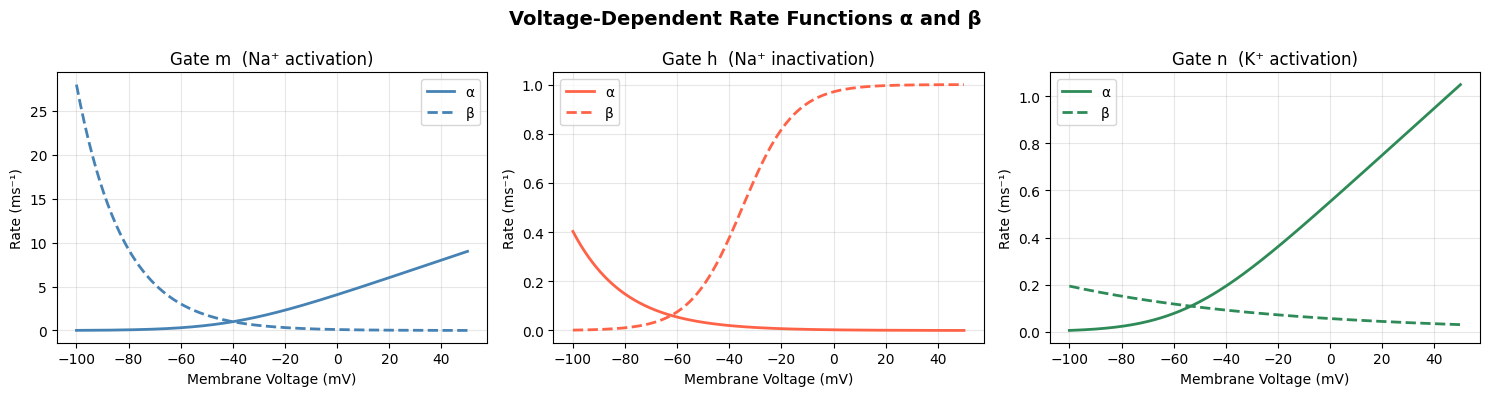

In [2]:
def alpha_m(V):
    """Na+ activation: opening rate"""
    return 0.1 * (V + 40.0) / (1.0 - np.exp(-(V + 40.0) / 10.0))

def beta_m(V):
    """Na+ activation: closing rate"""
    return 4.0 * np.exp(-(V + 65.0) / 18.0)

def alpha_h(V):
    """Na+ inactivation: opening rate"""
    return 0.07 * np.exp(-(V + 65.0) / 20.0)

def beta_h(V):
    """Na+ inactivation: closing rate"""
    return 1.0 / (1.0 + np.exp(-(V + 35.0) / 10.0))

def alpha_n(V):
    """K+ activation: opening rate"""
    return 0.01 * (V + 55.0) / (1.0 - np.exp(-(V + 55.0) / 10.0))

def beta_n(V):
    """K+ activation: closing rate"""
    return 0.125 * np.exp(-(V + 65.0) / 80.0)


# ─── Visualize the rate functions ─────────────────────────────────────────────
V_range = np.linspace(-100, 50, 300)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Voltage-Dependent Rate Functions α and β', fontsize=14, fontweight='bold')

for ax, (a_fn, b_fn, label, color) in zip(axes, [
    (alpha_m, beta_m, 'm  (Na⁺ activation)', 'steelblue'),
    (alpha_h, beta_h, 'h  (Na⁺ inactivation)', 'tomato'),
    (alpha_n, beta_n, 'n  (K⁺ activation)', 'seagreen'),
]):
    ax.plot(V_range, [a_fn(v) for v in V_range], label='α', color=color, lw=2)
    ax.plot(V_range, [b_fn(v) for v in V_range], label='β', color=color, lw=2, linestyle='--')
    ax.set_title(f'Gate {label}')
    ax.set_xlabel('Membrane Voltage (mV)')
    ax.set_ylabel('Rate (ms⁻¹)')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('rate_functions.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. The ODE System

We pack $V$, $m$, $h$, $n$ into a state vector and define their derivatives.

In [3]:
def hodgkin_huxley(t, y, I_ext):
    """
    Hodgkin-Huxley ODE system.
    
    Parameters
    ----------
    t     : float  — current time (ms)
    y     : array  — state vector [V, m, h, n]
    I_ext : float  — external current injection (µA/cm²)
    
    Returns
    -------
    dydt  : array  — derivatives [dV/dt, dm/dt, dh/dt, dn/dt]
    """
    V, m, h, n = y

    # Ion currents
    I_Na = gNa * m**3 * h * (V - ENa)
    I_K  = gK  * n**4     * (V - EK)
    I_L  = gL             * (V - EL)

    # Membrane voltage (capacitor equation)
    dVdt = (I_ext - I_Na - I_K - I_L) / Cm

    # Gating variable dynamics
    dmdt = alpha_m(V) * (1 - m) - beta_m(V) * m
    dhdt = alpha_h(V) * (1 - h) - beta_h(V) * h
    dndt = alpha_n(V) * (1 - n) - beta_n(V) * n

    return [dVdt, dmdt, dhdt, dndt]


def get_steady_state(V0=-65.0):
    """Compute steady-state gating variables at resting potential V0."""
    m0 = alpha_m(V0) / (alpha_m(V0) + beta_m(V0))
    h0 = alpha_h(V0) / (alpha_h(V0) + beta_h(V0))
    n0 = alpha_n(V0) / (alpha_n(V0) + beta_n(V0))
    return m0, h0, n0

m0, h0, n0 = get_steady_state()
print(f"Steady-state initial conditions at V = -65 mV:")
print(f"  m₀ = {m0:.4f}")
print(f"  h₀ = {h0:.4f}")
print(f"  n₀ = {n0:.4f}")

Steady-state initial conditions at V = -65 mV:
  m₀ = 0.0529
  h₀ = 0.5961
  n₀ = 0.3177


## 4. Simulation: Single Action Potential

We inject a brief current pulse and watch a single action potential unfold.

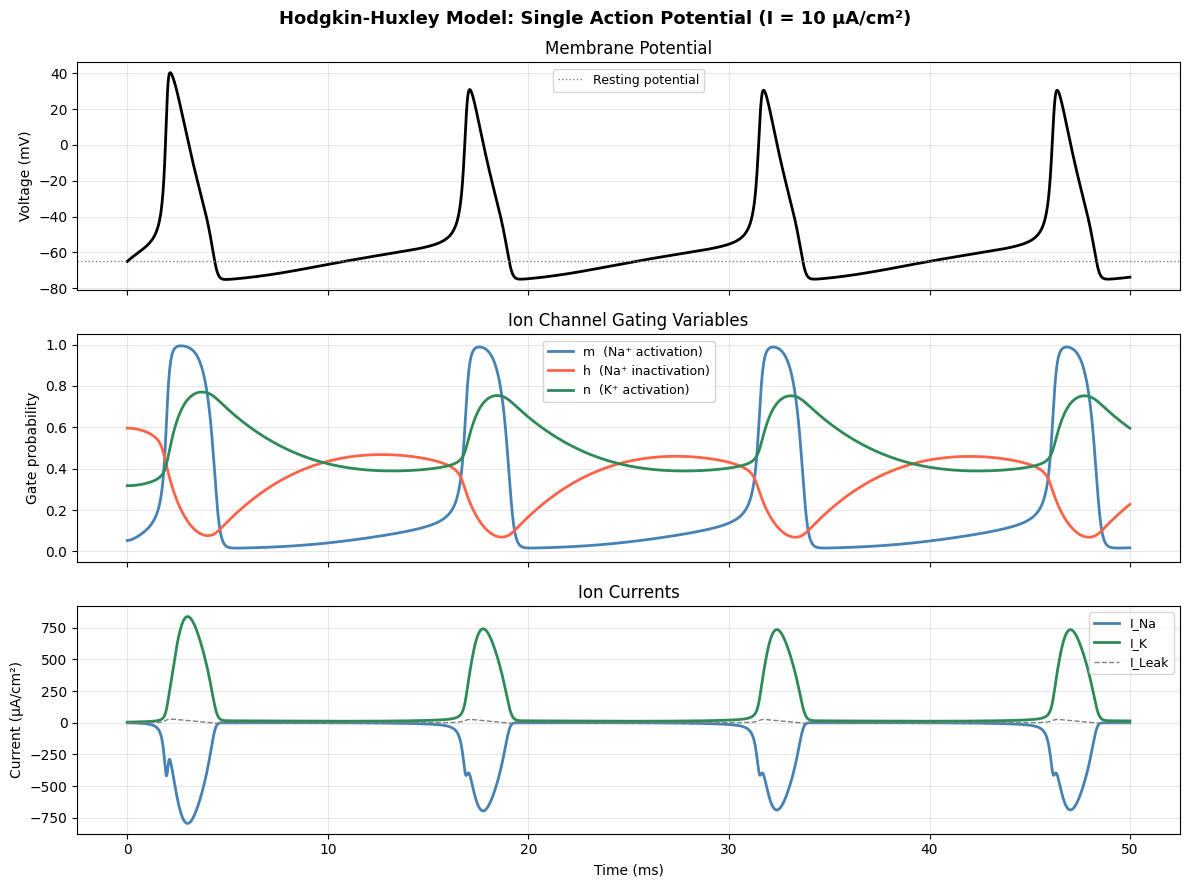

In [4]:
def run_simulation(I_ext=10.0, t_start=0, t_end=50, dt=0.01):
    """
    Run the HH simulation.
    
    Parameters
    ----------
    I_ext  : float — injected current (µA/cm²)
    t_end  : float — simulation duration (ms)
    dt     : float — time step (ms)
    """
    t_span = (t_start, t_end)
    t_eval = np.arange(t_start, t_end, dt)
    V0 = -65.0
    m0, h0, n0 = get_steady_state(V0)
    y0 = [V0, m0, h0, n0]

    sol = solve_ivp(
        hodgkin_huxley,
        t_span,
        y0,
        args=(I_ext,),
        t_eval=t_eval,
        method='RK45',
        max_step=dt
    )
    return sol


sol = run_simulation(I_ext=10.0, t_end=50)
t = sol.t
V, m, h, n = sol.y

# ─── Plot ─────────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)
fig.suptitle('Hodgkin-Huxley Model: Single Action Potential (I = 10 µA/cm²)', 
             fontsize=13, fontweight='bold')

# Membrane voltage
axes[0].plot(t, V, color='black', lw=2)
axes[0].set_ylabel('Voltage (mV)')
axes[0].axhline(-65, color='gray', linestyle=':', lw=1, label='Resting potential')
axes[0].legend(fontsize=9)
axes[0].grid(alpha=0.3)
axes[0].set_title('Membrane Potential')

# Gating variables
axes[1].plot(t, m, color='steelblue', lw=2, label='m  (Na⁺ activation)')
axes[1].plot(t, h, color='tomato',    lw=2, label='h  (Na⁺ inactivation)')
axes[1].plot(t, n, color='seagreen',  lw=2, label='n  (K⁺ activation)')
axes[1].set_ylabel('Gate probability')
axes[1].set_ylim(-0.05, 1.05)
axes[1].legend(fontsize=9)
axes[1].grid(alpha=0.3)
axes[1].set_title('Ion Channel Gating Variables')

# Individual currents
I_Na = gNa * m**3 * h * (V - ENa)
I_K  = gK  * n**4     * (V - EK)
I_L  = gL             * (V - EL)

axes[2].plot(t, I_Na, color='steelblue', lw=2, label='I_Na')
axes[2].plot(t, I_K,  color='seagreen',  lw=2, label='I_K')
axes[2].plot(t, I_L,  color='gray',      lw=1, label='I_Leak', linestyle='--')
axes[2].set_ylabel('Current (µA/cm²)')
axes[2].set_xlabel('Time (ms)')
axes[2].legend(fontsize=9)
axes[2].grid(alpha=0.3)
axes[2].set_title('Ion Currents')

plt.tight_layout()
plt.savefig('single_action_potential.png', dpi=150, bbox_inches='tight')
plt.show()

### What we observe:

1. **Depolarization**: The injected current depolarizes the membrane. When it crosses threshold (~-55 mV), fast Na⁺ channels open (m rises rapidly), driving a massive inward Na⁺ current and the rapid upswing of the action potential.
2. **Repolarization**: Na⁺ channels inactivate (h falls) while K⁺ channels slowly open (n rises), driving repolarization.
3. **Afterhyperpolarization**: K⁺ channels remain open briefly after repolarization, pushing the membrane below resting potential (undershoot).
4. **Refractory period**: During h inactivation and n activation, the neuron cannot fire another spike — this is the basis for the **unidirectional propagation** of action potentials and limits firing rates.

## 5. Repetitive Firing and F-I Curve

With sustained current injection, neurons fire repetitively. The **F-I curve** (firing rate vs. injected current) is a fundamental characterization of neuronal excitability.

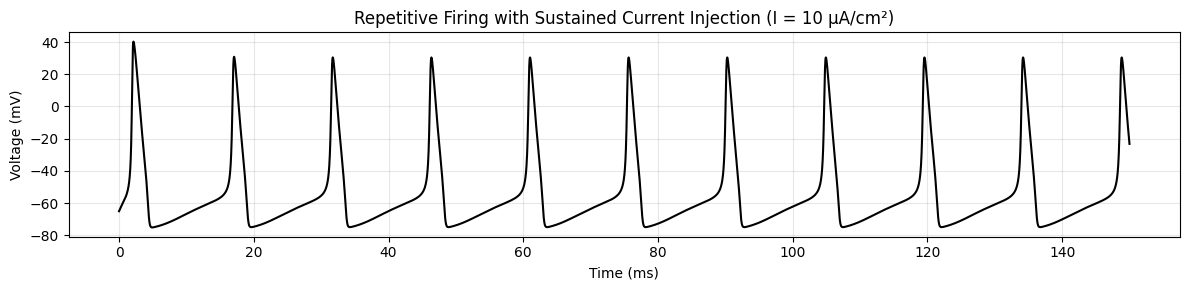

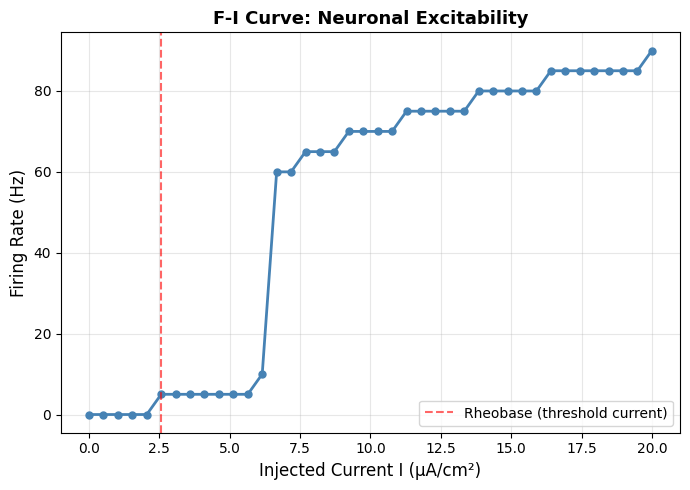

In [5]:
def count_spikes(V, t, threshold=0.0):
    """Count spikes by detecting upward threshold crossings."""
    above = V > threshold
    crossings = np.where(np.diff(above.astype(int)) == 1)[0]
    return len(crossings)


# ─── Simulate sustained firing ────────────────────────────────────────────────
sol_sustained = run_simulation(I_ext=10.0, t_end=150)

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(sol_sustained.t, sol_sustained.y[0], color='black', lw=1.5)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Voltage (mV)')
ax.set_title('Repetitive Firing with Sustained Current Injection (I = 10 µA/cm²)')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('repetitive_firing.png', dpi=150, bbox_inches='tight')
plt.show()


# ─── F-I curve ────────────────────────────────────────────────────────────────
I_values = np.linspace(0, 20, 40)
firing_rates = []
t_sim = 200  # ms

for I in I_values:
    sol_fi = run_simulation(I_ext=I, t_end=t_sim)
    n_spikes = count_spikes(sol_fi.y[0], sol_fi.t)
    rate = (n_spikes / t_sim) * 1000  # convert to Hz
    firing_rates.append(rate)

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(I_values, firing_rates, 'o-', color='steelblue', lw=2, markersize=5)
ax.set_xlabel('Injected Current I (µA/cm²)', fontsize=12)
ax.set_ylabel('Firing Rate (Hz)', fontsize=12)
ax.set_title('F-I Curve: Neuronal Excitability', fontsize=13, fontweight='bold')
ax.axvline(x=I_values[next(i for i,r in enumerate(firing_rates) if r > 0)],
           color='red', linestyle='--', alpha=0.6, label='Rheobase (threshold current)')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('fi_curve.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Phase Plane Analysis

We can reduce the HH model to 2D by plotting V against n (a slow variable). This reveals the **limit cycle** — the closed orbit in phase space that corresponds to repetitive firing.

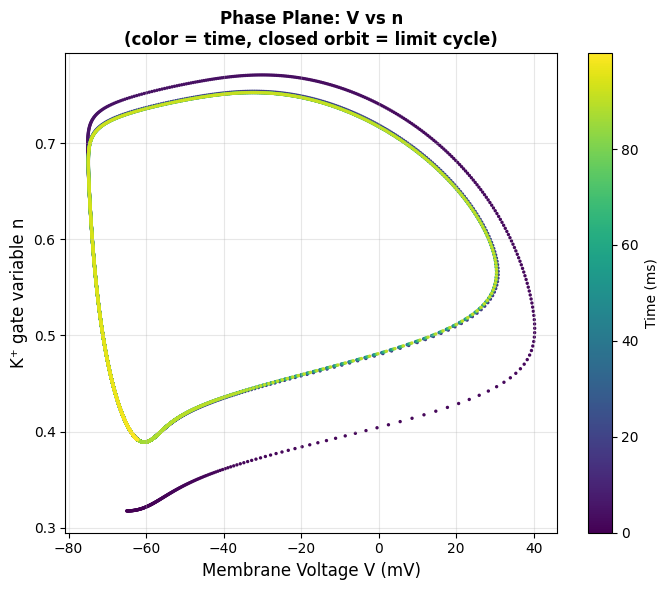

In [8]:
sol_phase = run_simulation(I_ext=10.0, t_end=100)
V_phase = sol_phase.y[0]
n_phase = sol_phase.y[3]

fig, ax = plt.subplots(figsize=(7, 6))
sc = ax.scatter(V_phase, n_phase, c=sol_phase.t, cmap='viridis', s=2)
plt.colorbar(sc, label='Time (ms)')
ax.set_xlabel('Membrane Voltage V (mV)', fontsize=12)
ax.set_ylabel('K⁺ gate variable n', fontsize=12)
ax.set_title('Phase Plane: V vs n\n(color = time, closed orbit = limit cycle)', 
             fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('phase_plane.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Refractory Period and Spike Timing

Two current pulses separated by varying intervals demonstrate the **absolute and relative refractory periods** — fundamental constraints on neural coding.

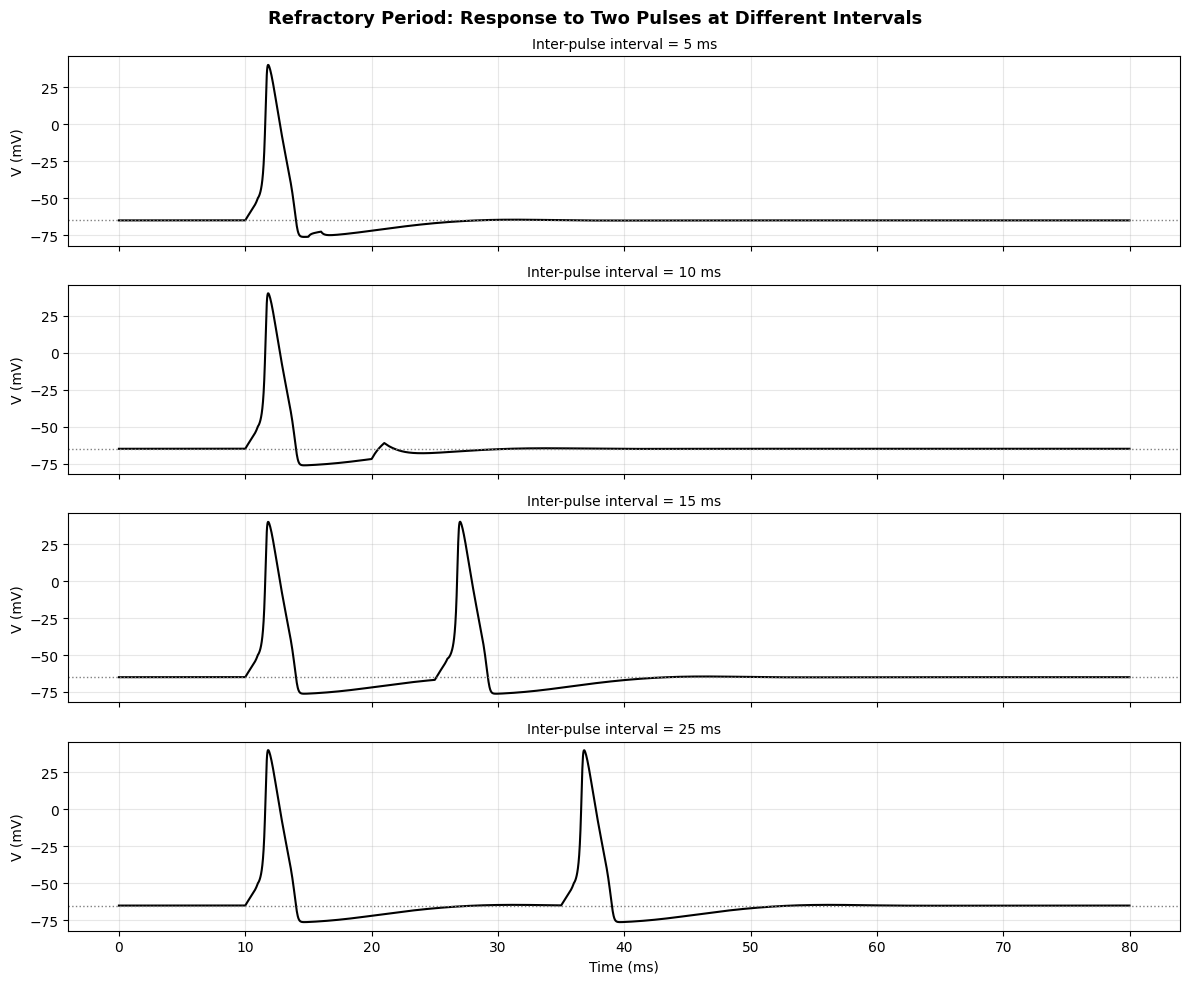

In [9]:
def run_two_pulses(interval_ms, pulse_duration=1.0, I_amp=15.0, t_end=80):
    """
    Simulate two brief current pulses separated by `interval_ms`.
    First pulse at t=10ms, second at t=10+interval_ms.
    """
    dt = 0.025
    t_eval = np.arange(0, t_end, dt)
    t1_start, t2_start = 10.0, 10.0 + interval_ms

    def hh_pulses(t, y):
        in_pulse1 = t1_start <= t <= t1_start + pulse_duration
        in_pulse2 = t2_start <= t <= t2_start + pulse_duration
        I = I_amp if (in_pulse1 or in_pulse2) else 0.0
        return hodgkin_huxley(t, y, I)

    V0 = -65.0
    m0_, h0_, n0_ = get_steady_state(V0)
    sol = solve_ivp(hh_pulses, (0, t_end), [V0, m0_, h0_, n0_],
                    t_eval=t_eval, method='RK45', max_step=dt)
    return sol


intervals = [5, 10, 15, 25]
fig, axes = plt.subplots(len(intervals), 1, figsize=(12, 10), sharex=True)
fig.suptitle('Refractory Period: Response to Two Pulses at Different Intervals',
             fontsize=13, fontweight='bold')

for ax, interval in zip(axes, intervals):
    sol = run_two_pulses(interval)
    ax.plot(sol.t, sol.y[0], color='black', lw=1.5)
    ax.axhline(-65, color='gray', linestyle=':', lw=1)
    ax.set_ylabel('V (mV)')
    ax.set_title(f'Inter-pulse interval = {interval} ms', fontsize=10)
    ax.grid(alpha=0.3)

axes[-1].set_xlabel('Time (ms)')
plt.tight_layout()
plt.savefig('refractory_period.png', dpi=150, bbox_inches='tight')
plt.show()

## Summary

In this notebook we:

1. **Implemented** the full Hodgkin-Huxley model from scratch in Python using only NumPy and SciPy
2. **Visualized** the voltage-dependent rate functions that underlie channel gating
3. **Simulated** a single action potential and decomposed it into its ionic components
4. **Characterized** neuronal excitability via the F-I curve and identified the rheobase
5. **Analyzed** the phase plane geometry, revealing the limit cycle of repetitive firing
6. **Demonstrated** the absolute and relative refractory periods using paired pulse stimulation

## Next Steps

The HH model of a single neuron is the building block for network models. In the next notebook, we will connect many such neurons into an **excitatory-inhibitory network** and observe how their collective dynamics give rise to **population-level oscillations** — the same class of phenomena as hippocampal sharp-wave ripples and gamma oscillations.

---

## References

- Hodgkin, A.L. & Huxley, A.F. (1952). A quantitative description of membrane current and its application to conduction and excitation in nerve. *Journal of Physiology*, 117, 500–544.
- Dayan, P. & Abbott, L.F. (2001). *Theoretical Neuroscience: Computational and Mathematical Modeling of Neural Systems*. MIT Press. (Chapter 5)
- Ermentrout, B. & Terman, D. (2010). *Mathematical Foundations of Neuroscience*. Springer.